In [1]:
import numpy as np
from pl_bolts.datamodules import SklearnDataModule

from torch.utils.data import DataLoader, TensorDataset
import torch
from aeon.datasets import load_classification
import torch
from lightning import LightningModule, Trainer, seed_everything
from torch import nn
from torch.nn import functional as F

/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/francesco/mi

In [2]:
import numpy as np
X, y = load_classification("CBF")
X = torch.Tensor(X[:, :, :-1])
X.shape

torch.Size([930, 1, 127])

In [3]:
import lightning as L
import torch.nn.functional as F

class TreeDataModule(L.LightningDataModule):
    def __init__(self, X_train, X_val, X_test, **dataloader_kwargs):
        super().__init__()

        self.X_train = TensorDataset(torch.Tensor(X_train))
        self.X_val = TensorDataset(torch.Tensor(X_val))
        self.X_test = TensorDataset(torch.Tensor(X_test))
        self.dataloader_kwargs = dataloader_kwargs

    def train_dataloader(self):
        return DataLoader(self.X_train, **self.dataloader_kwargs)

    def val_dataloader(self):
        return DataLoader(self.X_val, **self.dataloader_kwargs)

    def test_dataloader(self):
        return DataLoader(self.X_test, **self.dataloader_kwargs)

    def predict_dataloader(self):
        return DataLoader(self.X_test, **self.dataloader_kwargs)

In [4]:
from torch import nn

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        in_channels = 1
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=8,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=8,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.ReLU(),
        )

        self.fc = nn.Linear(32 * (self.n_nodes + 1) // 8, latent_dim)

    def forward(self, x):
        # input shape is (batch_size, 1, n_nodes)
        x = F.pad(x, (0, 1))  # add one fake node
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        in_channels = 1

        self.fc = nn.Linear(latent_dim, 32 * (self.n_nodes + 1) // 8)

        self.conv = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose1d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose1d(
                in_channels=8,
                out_channels=in_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 32, (self.n_nodes + 1) // 8)
        out = self.conv(out)
        out = out[:, :, :-1]
        return out

In [40]:
class TreeVAE(LightningModule):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        kl_coeff: float = 0.1,
        latent_dim: int = 4,
        lr: float = 1e-4,
        **kwargs,
    ) -> None:
        super().__init__()

        self.save_hyperparameters()

        self.encoder = encoder
        self.decoder = decoder

        self.lr = lr
        self.kl_coeff = kl_coeff
        self.latent_dim = latent_dim

        self.fc_mu = nn.Linear(self.latent_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return self.decoder(z)

    def _run_step(self, x):
        x = self.encoder(x)
        # print(x.shape)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x = batch[0]
        # print(x.shape)
        z, x_hat, p, q = self._run_step(x)

        recon_loss = F.mse_loss(x_hat, x, reduction="mean")

        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }

        return loss, logs

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [41]:
dataset = TreeDataModule(X_train=X, X_val=X, X_test=X, batch_size=32)
LATENT_DIM = 4

encoder = Encoder(
    latent_dim=LATENT_DIM, n_nodes=X.shape[2]
)
decoder = Decoder(
    latent_dim=LATENT_DIM, n_nodes=X.shape[2]
)
model = TreeVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=LATENT_DIM
)

/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


In [42]:
trainer = Trainer(max_epochs=100)
trainer.fit(model, datamodule=dataset)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 4.1 K  | train
1 | decoder | Decoder | 4.5 K  | train
2 | fc_mu   | Linear  | 20     | train
3 | fc_var  | Linear  | 20     | train
--------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/francesco/miniforge3/envs/timeseries_dl/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [43]:
Z = model.encoder.forward(X).detach().numpy()
Z.shape

(930, 4)

In [44]:
import seaborn as sns
import pandas as pd

<Axes: xlabel='0', ylabel='1'>

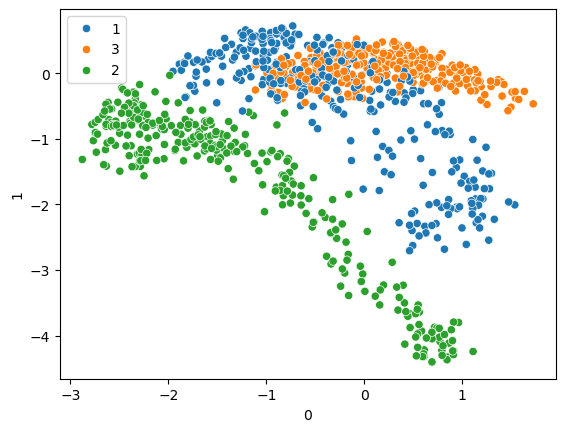

In [45]:
sns.scatterplot(data=pd.DataFrame(Z), x=0, y=1, hue=y)

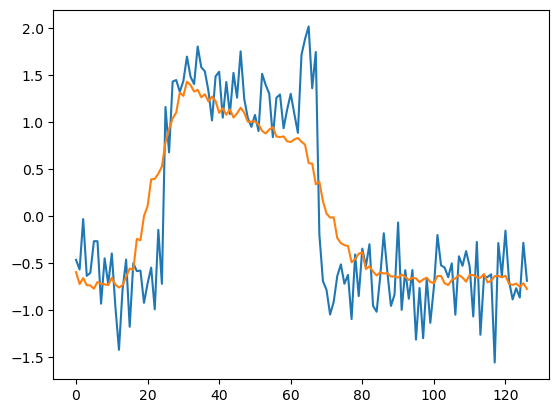

In [46]:
import matplotlib.pyplot as plt
i = 2
plt.plot(X[i, 0].numpy())
plt.plot(model.forward(X[i:i+1]).detach().numpy().ravel())